# 3 - Neural Machine Translation by Jointly Learning to Align and Translate

120220227 최규식

[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). 논문구현.

## Introduction

기존에 제안되었던 neural machine translation models는 대부분 encoder-decoder 구조로 이루어져 있었다.
enocder neural network는 source sentence를 fixed-length vector로 encode하며, decoder가 encoded된 벡터로 부터 번역본을 출력하는 방식.
그러나 기존의 방식은 fixed-length vector로 compress하는 방식으로, 길이가 긴 문장에 대해서는 어려움이 있었음.

이를 해결하기 위해 encoder-decoder 의 extension을 제안. 즉 attention mechanism을 적용하여 decoder에서 translation word가 나올때 source sentence에서 해당 부분과 가장 relevant한 부분이 어딘지 찾고 이와 가장 연관된 context vector와 previous generated target words를 이용해 predict한다.

가장 중요한 차별점은 전체 input sentence를 fixed sized vector로 압축하는것이 아니고 input sentence를 sequence of vectors로 encode한 후 decoding translation 과정에서 encoded vectors에서 연관된 부분들을 찾아서 사용한다는 것. 


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

## Random Seed 설정
실행시 마다 동일한 결과를 도출하기 위한 random seed 부여

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

독일어 모델 de_core_news_sm, 영어 모델 en_core_web_sm 모델 로드.
해당 모델은 input text의 Tokenize를 위해 사용됨.

In [4]:
"""
text tokenize 를 위해 spaCy의 Tokenization 모델을 불러옴.
"""

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

doc = spacy_en('I am a boy')
for token in doc:
    print(token.text, token.lemma_, token.pos_)

I I PRON
am be AUX
a a DET
boy boy NOUN


tokenizer 함수 정의.
input : 입력 텍스트
output : string list

In [5]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

print(tokenize_en("i am a boy"))

['i', 'am', 'a', 'boy']


torchtext Field 클래스로 Source sentence, Target sentence를 어떻게 전처리할 지 결정한다.

In [7]:
"""
torchtext의 Field를 활용해 tokenize 된 데이터를 tensor로 변환
"""

SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Multi30k 데이터셋의 de, en 언어에 해당하는 train, val, test 데이터 불러옴.

In [8]:
"""
torchtext에서 Multi30k 데이터셋을 불러와 split 진행하며, 독일어 데이터는 SRC, 영어 데이터는 TRG 필드로
"""

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

최소빈도 2를 가지는 Vocabulary 생성

In [9]:
"""
데이터셋으로 vocabulary 생성.. 최소 빈도 2로 설정하며 워드 임베딩 vector를 지정할 수 도 있음
본 데이터셋에서 가장 빈도가 높은 vocab은 아래 셀과 같음
"""

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [22]:
print(len(train_data), len(valid_data), len(test_data))

29000 1014 1000


In [11]:
print(SRC.vocab.freqs.most_common(10))
print(TRG.vocab.freqs.most_common(10))

[('.', 28809), ('ein', 18851), ('einem', 13711), ('in', 11895), ('eine', 9909), (',', 8938), ('und', 8925), ('mit', 8843), ('auf', 8745), ('mann', 7805)]
[('a', 49165), ('.', 27623), ('in', 14886), ('the', 10955), ('on', 8035), ('man', 7781), ('is', 7525), ('and', 7379), ('of', 6871), ('with', 6179)]


Torch device 설정

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

128 개의 데이터로 이루어진 Batch 구성.

In [31]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

## 3. Learning to Align and Translate
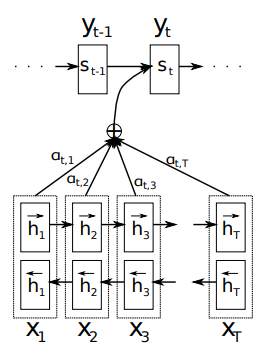

### Decoder
$p(y_i|\{y_1,...,y_{i-1}\},x)=g(y_{i-1},s_i,c_i)$

$y_i$ : i 번째 target word

$g$ : $y_{i-1}, s_i, c_i$를 입력받아 $y_i$의 확률을 계산하는 non-linear, multi-layered function

$s_i = f(s_{i-1}, y_{i-1}, c_i)$, decoder의 i번째 hidden state

$f$ : RNN

$c_i = \Sigma^{T_x}_{j=1}\alpha_{i,j}h_j$

$\alpha_{i,j} = \cfrac{exp(e_{i,j})}{\Sigma^{T_x}_{k=1}{exp(e_{i,k})}}$

$e_{i,j}=a(s_{i-1},h_j)$

$\alpha_{i,j}$는 $y_i$와 $x_j$가 align될 softmax probability이며, $c_i$는 $\alpha_{ij}$의 확률로 annotation $h_j$의 기댓값.
확률 $\alpha_{i,j}$는 decoder의 previous hidden state $s_{i-1}$로 $s_i$를 결정하는 과정에서 encoder hidden state $h_j$와 얼마나 연관성이 있는지, 또는 source sequence의 어떤 부분에 집중해야 하는지 결정하는 의미가 있다고 볼 수 있다.

### Encoder
보통 RNN은 input sequence의 $x_1$ 부터 $x_{T_x}$ 까지 순차적으로 읽어들여 context vector를 생성하지만 여기서는 Bidirectional RNN을 사용하여 $x_1$ ~ $x_{T_x}$ 를 순차적으로 읽는 forward RNN과 $x_{T_x}$ ~ $x_1$ 방향으로 읽는 backwards RNN을 구성하고 이 hidden states들을 concatenation 하여 $h_j = [\overrightarrow{h_j^{\top}};\overleftarrow{h_j^{\top}}]$ 로 hidden state 만든다.

In [32]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        """
        embedding block : input dimension -> embedding dimension
        rnn block : embedded dimension -> hidden state 의 bidirectional GRU
        fully connected : bidirectional GRU의 output -> decoder hidden state
        dropout : 드롭아웃
        """
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size] : 입력 문장 토큰의 개수, 배치사이즈
        #self.embedding(src) 를 통해 [토큰 개수, 배치사이즈] -> [토큰 개수, 배치사이즈, 임베딩차원]
        print('src shape : ', src.shape)
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        print('embedded shape : ', embedded.shape)
        #bidirectional GRU 에 embedding을 태워 outputs, hidden state 얻어냄
        
        outputs, hidden = self.rnn(embedded)
        
        print('outputs : ', outputs.shape)
        print('hidden : ', hidden.shape)
        
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        # 현재 GRU 는 single layer임.
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        '''
        initial decoder hidden is final hidden state of the forwards and backwards 
        encoder RNNs fed through a linear layer
        hidden state의 forward pass, backward pass 결과를 concat 후 fully connected layer 통과, tanh nonlinearity 적용
        encoder hidden dimension * 2 -> decoder hidden dimension으로 mapping
        '''
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        print('hidden after linear layer : ', hidden.shape)
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

$\alpha_{i,j} = \cfrac{exp(e_{i,j})}{\Sigma^{T_x}_{k=1}{exp(e_{i,k})}}$

$e_{i,j}=a(s_{i-1},h_j)$

In [48]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        """
        attention layer
        인코더의 모든 hidden state h1, h2, ..., hT와 previous decoder hidden state concat하여 attention 수행
        논문의 alignment model a에 해당하는 코드.
        self.attn : encoder ouput + decoder의 initial hidden state의 attention 연산
        self.v : attention 연산 결과와 [1, decoder hidden dimension] vector v와 matrix multiplication
        
        """
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        """
        인코더와 디코더의 hidden layer를 concatenate 한 후 linear layer를 통해 input 문장길이와 맞도록 조절
        hidden : [batch_size, decoder hidden dimension]
        encoder_outputs : [src len, batch size, enc hid dim * 2]
        """
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        #unsqueeze : 1인 차원 만드는 함수
        #unsqeeze(1) : [batch_size, dec_hid_dim] -> [batch_size, 1, dec_hid_dim]
        #repeat(1, src_len, 1) : [batch_size, 1, dec_hid_dim] -> [batch_size, src_len, dec_hid_dim]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        print(hidden.shape)
        #encoder_outputs : [src_len, batch_size, enc_hid_dim*2] -> [batch_size, src_len, enc_hid_dim*2]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))
        print(energy.shape)
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](assets/seq2seq10.png)

The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [49]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        """
        hidden layer에서 각 step의 output을 input으로 받는다.
        각 step의 output을 emb_dim 으로 차원을 맞춘 후 hidden layer, encoder_output으로 Attention 계산.
        계산된 Attention을 디코더의 embedding 벡터와 concat 후 hidden layer과 함께 디코더 GRU에 포워딩.
        fc layer 추가하여 output dim 맞춘다.
        """
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

### Seq2Seq

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [50]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        #Attention 산출을 위해 encoder_outputs 연산
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one.

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [51]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [52]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Calculate the number of parameters. We get an increase of almost 50% in the amount of parameters from the last model. 

In [53]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


We create an optimizer.

In [54]:
optimizer = optim.Adam(model.parameters())

We initialize the loss function.

In [55]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

We then create the training loop...

In [56]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [57]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Finally, define a timing function.

In [58]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [59]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

src shape :  torch.Size([28, 128])
embedded shape :  torch.Size([28, 128, 256])
outputs :  torch.Size([28, 128, 1024])
hidden :  torch.Size([2, 128, 512])
hidden after linear layer :  torch.Size([128, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size([128, 28, 512])
torch.Size

Finally, we test the model on the test set using these "best" parameters.

In [45]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

src shape :  torch.Size([10, 128])
embedded shape :  torch.Size([10, 128, 256])
outputs :  torch.Size([10, 128, 1024])
hidden :  torch.Size([2, 128, 512])
hidden after linear layer :  torch.Size([128, 512])
src shape :  torch.Size([12, 128])
embedded shape :  torch.Size([12, 128, 256])
outputs :  torch.Size([12, 128, 1024])
hidden :  torch.Size([2, 128, 512])
hidden after linear layer :  torch.Size([128, 512])
src shape :  torch.Size([13, 128])
embedded shape :  torch.Size([13, 128, 256])
outputs :  torch.Size([13, 128, 1024])
hidden :  torch.Size([2, 128, 512])
hidden after linear layer :  torch.Size([128, 512])
src shape :  torch.Size([14, 128])
embedded shape :  torch.Size([14, 128, 256])
outputs :  torch.Size([14, 128, 1024])
hidden :  torch.Size([2, 128, 512])
hidden after linear layer :  torch.Size([128, 512])
src shape :  torch.Size([16, 128])
embedded shape :  torch.Size([16, 128, 256])
outputs :  torch.Size([16, 128, 1024])
hidden :  torch.Size([2, 128, 512])
hidden after line

We've improved on the previous model, but this came at the cost of doubling the training time.

In the next notebook, we'll be using the same architecture but using a few tricks that are applicable to all RNN architectures - packed padded sequences and masking. We'll also implement code which will allow us to look at what words in the input the RNN is paying attention to when decoding the output.

In [46]:
def translate(model, iterator):
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            '''배치의 첫 데이터만을 사용
               vocabulary에서 token의 index로부터 단어를 찾아 출력'''
            if i == 1:
                break
            src = batch.src
            trg = batch.trg
            src, trg = src[:,0], trg[:,0]
            print("Source sentence")
            for token in src:
                print(SRC.vocab.itos[token])
            print("\nTarget sentence")
            for token in trg:
                print(TRG.vocab.itos[token])

            src, trg = src.reshape(-1, 1), trg.reshape(-1, 1)
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            output = output.argmax(dim=1)
            print("\nTranslated sentence")
            for token in output:
                print(TRG.vocab.itos[token])

In [47]:
translate(model, test_iterator)


Source sentence
<sos>
zwei
mittelgroße
hunde
laufen
über
den
schnee
.
<eos>

Target sentence
<sos>
two
medium
sized
dogs
run
across
the
snow
.
<eos>
<pad>
<pad>
<pad>
src shape :  torch.Size([10, 1])
embedded shape :  torch.Size([10, 1, 256])
outputs :  torch.Size([10, 1, 1024])
hidden :  torch.Size([2, 1, 512])
hidden after linear layer :  torch.Size([1, 512])

Translated sentence
two
steeplechase
-
dogs
are
running
through
the
snow
.
<eos>
<eos>
<eos>
